In [1]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
import nibabel as nib
import seaborn as sns
import matplotlib.pyplot as plt
from ipywidgets import widgets
import glob
import SUITPy as suit

from connectivity import constants as const
from connectivity import visualize as vis
from connectivity import nib_utils as nio

%reload_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

/Users/maedbhking/.local/share/virtualenvs/cerebellum_connectivity-DbxULmID/lib/python3.7/site-packages/nilearn/datasets/__init__.py:90: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


In [2]:
# initialize directories and load train and eval dataframes

vis.plotting_style()


df_train = vis.train_summary(summary_name="train_summary",
                            exps=['sc1'], 
                            models_to_exclude=['NNLS', 'PLSRegress'])

df_eval = vis.eval_summary(summary_name="eval_summary",
                           exps=['sc2'], 
                           models_to_exclude=['NNLS', 'PLSRegress'])

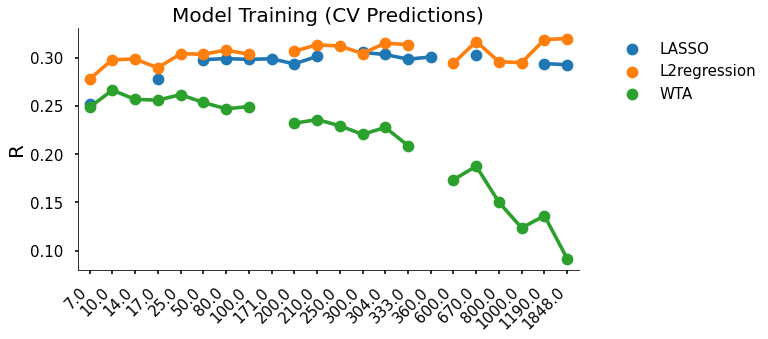

<Figure size 921.6x633.6 with 0 Axes>

In [124]:
# plot alpha curve for train CVs
# WTA

vis.plot_train_predictions(dataframe=df_train,
                           x='train_num_regions', 
                           methods=['LASSO', 'WTA', 'L2regression'], 
                           best_models=True,
                           hue='train_model'); 


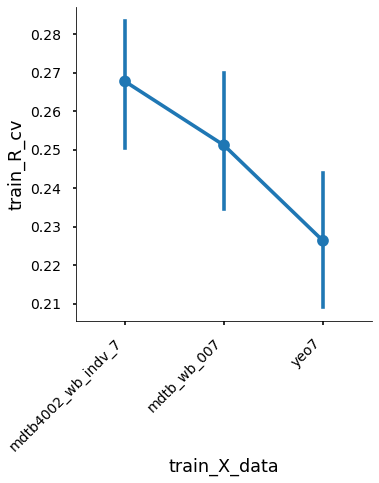

In [151]:
# Individual versus group parcellation (7-regions)

df_filter = df_train[df_train['train_X_data']\
                     .isin(['yeo7', 'mdtb_wb_007', 'mdtb4002_wb_indv_7'])]

df_filter = df_filter[df_filter['train_model'].isin(['L2regression'])]

sns.factorplot(x='train_X_data', 
               y="train_R_cv",  
               data=df_filter)
plt.xticks(rotation='45', ha='right');

No handles with labels found to put in legend.


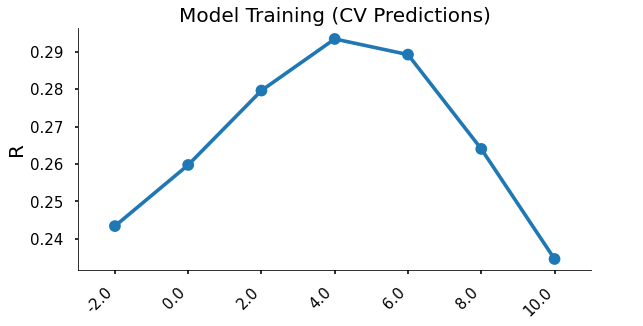

No handles with labels found to put in legend.


<Figure size 921.6x633.6 with 0 Axes>

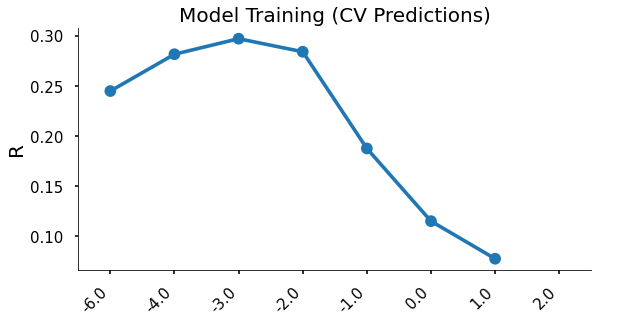

<Figure size 921.6x633.6 with 0 Axes>

In [340]:
# RIDGE
vis.plot_train_predictions(dataframe=df_train, 
                           x='train_hyperparameter',  
                           methods=['L2regression'],
                           best_models=False);

# LASSO
vis.plot_train_predictions(dataframe=df_train, # df_train.query('train_X_data=="Schaefer_7_100"') 
                           x='train_hyperparameter',  
                           methods=['LASSO'],
                           best_models=False);


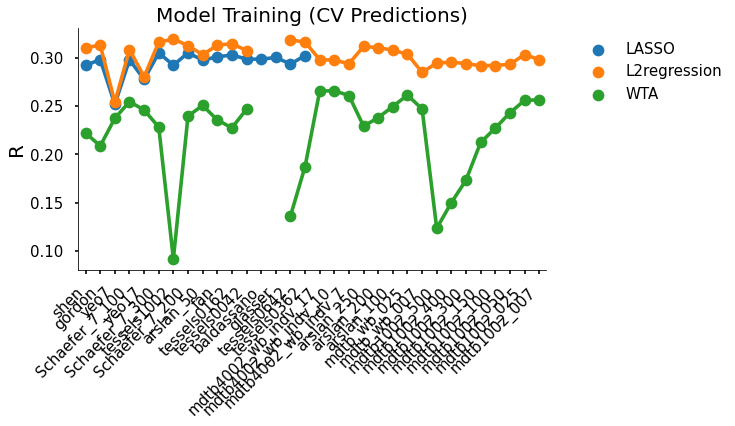

<Figure size 921.6x633.6 with 0 Axes>

In [20]:
# compare methods (cv)

vis.plot_train_predictions(dataframe=df_train,
                           x='train_X_data', 
                           hue='train_model', 
                           best_models=True,
                           methods=['L2regression', 'WTA', 'LASSO'])


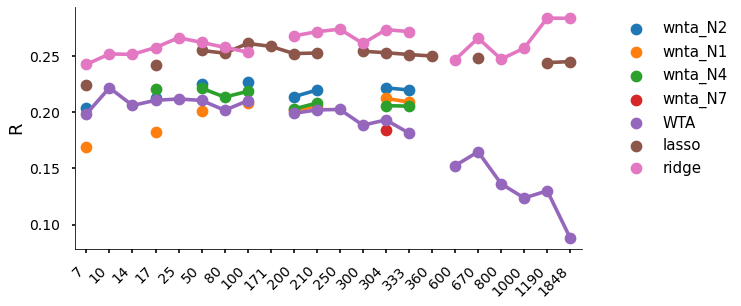

In [332]:
# Model evaluation - best models

vis.plot_eval_predictions(dataframe=df_eval,
                          hue='eval_model',
                          methods=['ridge', 'WTA', 'lasso'],
                          noiseceiling=False);

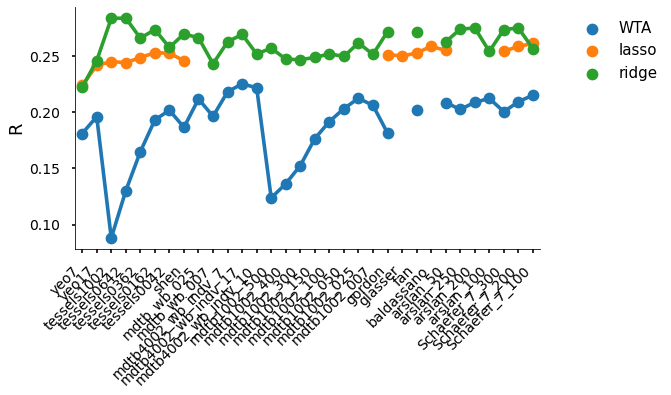

In [330]:
vis.plot_eval_predictions(dataframe=df_eval,
                          hue='eval_model',
                          x='eval_X_data', 
                          methods=['ridge', 'WTA', 'lasso'], # 'wnta_N4'
                          noiseceiling=False);

In [141]:
# Model evaluation (noise ceiling and predictions) - best model

#plot evaluation
# vis.plot_best_eval(exps=['sc1'])

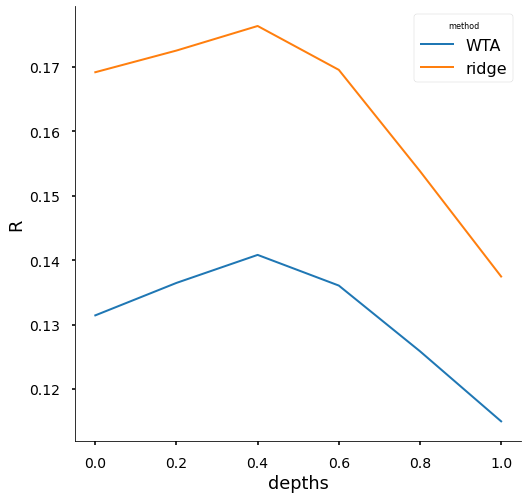

In [339]:
# summary of cortical depths

exp = 'sc2'
dirs = const.Dirs(exp_name=exp)

models = ['WTA_mdtb_wb_007', 'ridge_mdtb_wb_007_alpha_2']
# models = ['ridge_mdtb4002_wb_indv_7_alpha_2', 'WTA_mdtb4002_wb_indv_7']

df_all = pd.DataFrame()
for model in models:
    fpath = os.path.join(dirs.conn_eval_dir, model, 'group_R_vox.nii')

    # get evaluation at multiple depths
    data = suit.flatmap.vol_to_surf(fpath, depths=[0,0.2,0.4,0.6,0.8,1.0], stats=None)

    data_mean = np.nanmean(data,1)

    df = pd.DataFrame({'depths': np.array([0,0.2,0.4,0.6,0.8,1.0]),
                  'R': np.reshape(data_mean, (len(data_mean),)),
                  'model_name': np.repeat(model, len(data_mean)),
                  'method': np.repeat(model.split('_')[0], len(data_mean))})
    
    df_all = pd.concat([df_all, df])

plt.figure(figsize=(8,8))
sns.lineplot(x='depths', y='R', data=df_all, hue='method');

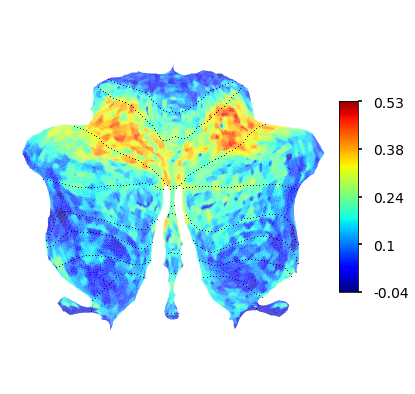

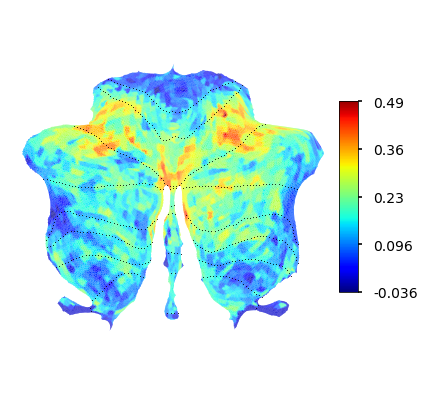

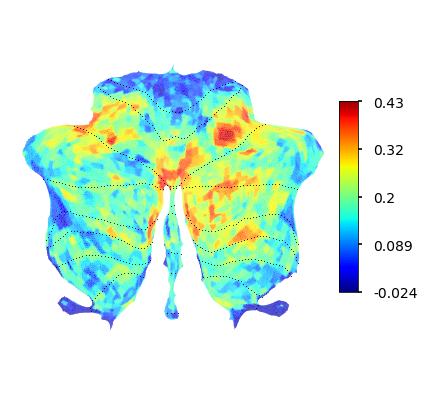

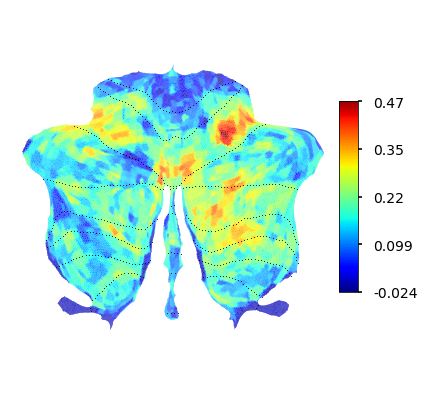

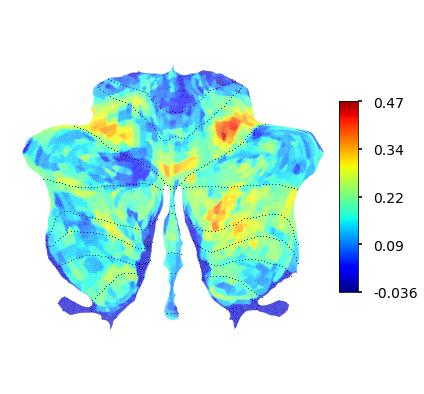

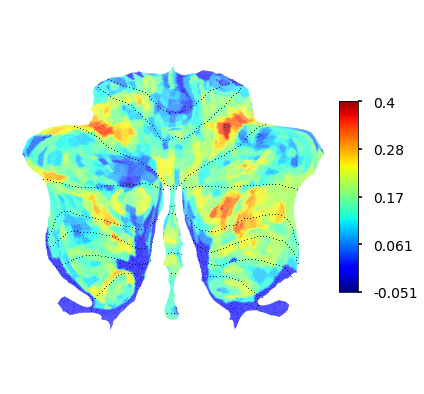

In [341]:
# map cortical depths across evaluation

exp = 'sc2'
dirs = const.Dirs(exp_name=exp)

fpath = os.path.join(dirs.conn_eval_dir, 'ridge_mdtb_wb_007_alpha_2', 'group_R_vox.nii')

# get evaluation at multiple depths
data = suit.flatmap.vol_to_surf(fpath, depths=[0,0.2,0.4,0.6,0.8,1.0], stats=None)

for idx in np.arange(6):
    suit.flatmap.plot(data[idx,:], overlay_type='func', colorbar=True, new_figure=True)

<AxesSubplot:>

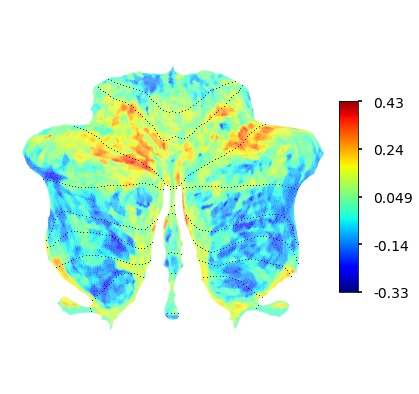

In [342]:
# superficial - deep layers

data_subtract = data[0,:] - data[-1,:]

suit.flatmap.plot(data_subtract, 
                  overlay_type='func', 
                  colorbar=True, 
                  new_figure=True)

interactive(children=(Dropdown(description='model_name', options=('lasso_Schaefer_7_100_alpha_-3', 'lasso_Scha…

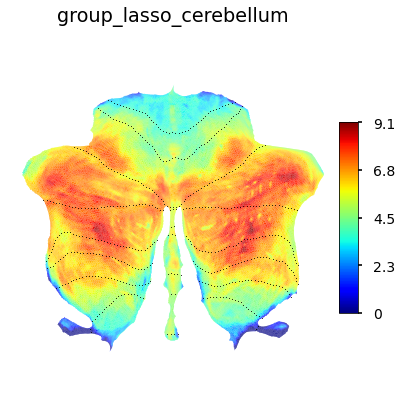

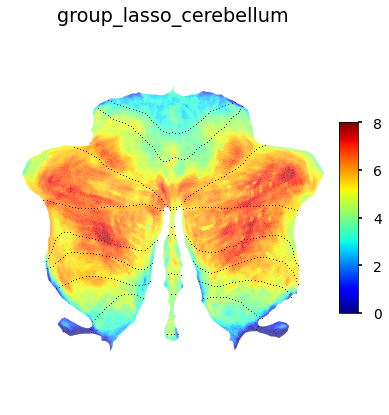

In [11]:
# lasso - number of non-zero weights for each voxel

exp = 'sc2'

dirs = const.Dirs(exp_name=exp)
models, _ = vis.get_best_models(dataframe=df_train,
                                train_exp=exp)

# filter models: lasso
models = [model for model in models if 'lasso' in model]

@widgets.interact(model_name=models,
                 colorbar=[True, False])

def map_lasso(model_name, colorbar):
    view = vis.map_lasso(exp=exp, 
                        model_name=model_name, 
                        colorbar=colorbar,
                        title=True
                       )
    

In [ ]:
# calculate coverage (%) of cerebellar labels

layer 0
layer 1
layer 2
layer 3
layer 4
layer 5


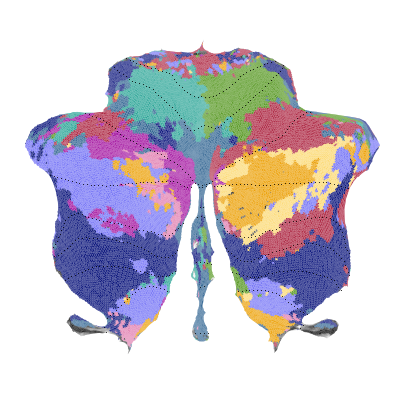

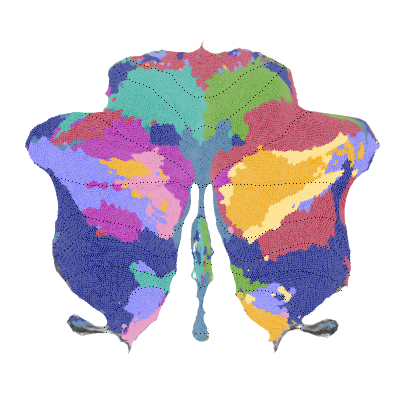

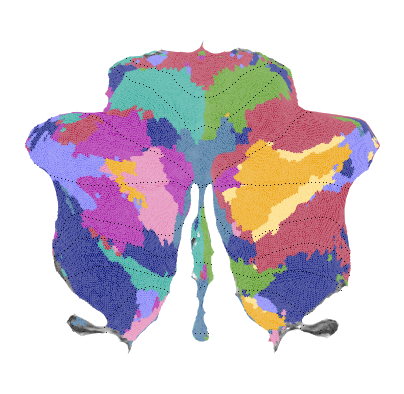

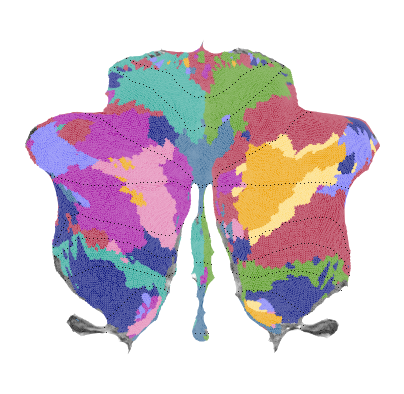

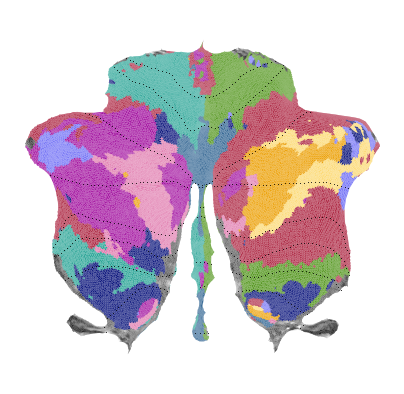

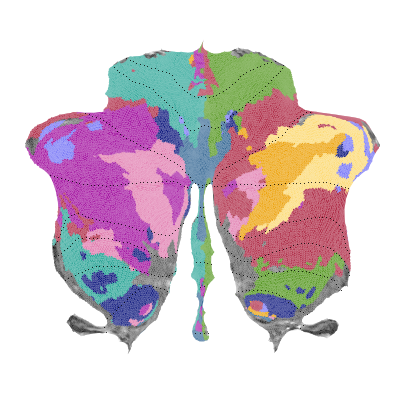

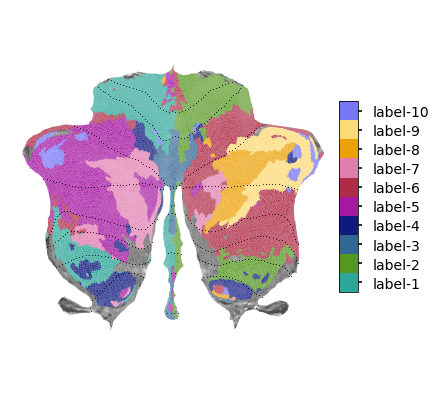

In [343]:
# map cortical depths across atlas

atlas = 'MDTB_10Regions' # atlas='MDTB_10Regions'

gifti_path = os.path.join(suit.flatmap._base_dir, 'example_data', f'{atlas}.label.gii')
rgba, cpal, cmap = nio.get_gifti_colors(fpath=gifti_path, ignore_0=False)

fpath = os.path.join(suit.flatmap._base_dir, 'example_data', f'{atlas}.nii')

# get evaluation at multiple depths
data = suit.flatmap.vol_to_surf(fpath, depths=[0,0.2,0.4,0.6,0.8,1.0], stats=None)

for idx in np.arange(6):
    suit.flatmap.plot(data[idx,:], overlay_type='label', cmap=rgba, new_figure=True)
    if idx==5:
        suit.flatmap.plot(data[idx,:], overlay_type='label', cmap=rgba, colorbar=True, new_figure=True)

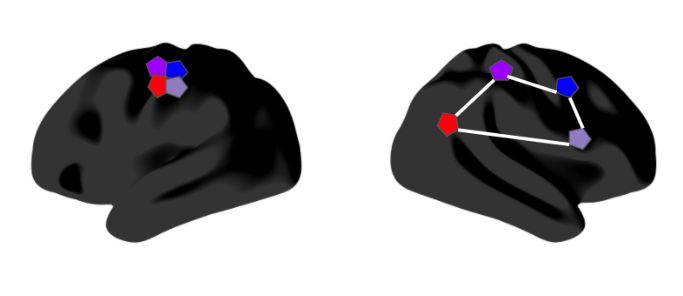

In [8]:
import matplotlib.image as mpimg

fname = os.path.join(dirs.figure, 'sparsity.png')

fig = plt.figure(figsize=(12,12))
img = mpimg.imread(fname)
plt.imshow(img)
plt.axis('off')
plt.show()

In [182]:
@widgets.interact(roi=['yeo7', 'yeo17', 'mdtb1002_007'])

def distance_matrix(roi):
    vis.show_distance_matrix(roi)

interactive(children=(Dropdown(description='roi', options=('yeo7', 'yeo17', 'mdtb1002_007'), value='yeo7'), Ou…

In [ ]:
###### visualize model weights - cerebellum or cortex

exp = 'sc1'

model, _ = vis.get_best_models(train_exp=exp)
model.insert(0,'best_model')

# get atlases
_, atlases = nio.get_cerebellar_atlases()

@widgets.interact(structure=['cerebellum', 'cortex'],
                 model_name=model,
                 hemisphere=[None, 'R', 'L'], 
                 colorbar=[True, False],
                 roi_summary=[True, False],
                 atlas=atlases)

def map_weights(structure, model_name, hemisphere, colorbar, roi_summary, atlas):
    view = vis.map_weights(structure, exp, model_name, hemisphere, rois=roi_summary, atlas=atlas)

interactive(children=(Dropdown(description='data', options=('R', 'R2', 'noiseceiling_XY_R', 'noiseceiling_Y_R'…

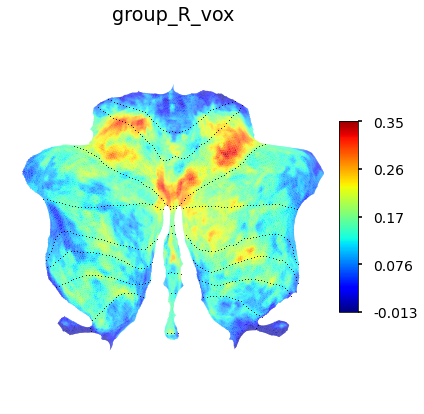

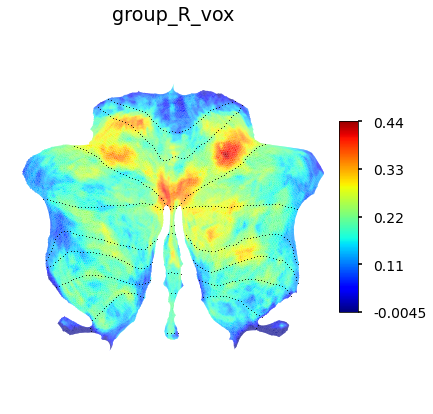

In [336]:
# visualize model evaluations

exp = 'sc2'

model, _ = vis.get_eval_models(exp=exp)
model.insert(0,'best_model')

@widgets.interact(data=['R','R2',
                        'noiseceiling_XY_R',
                        'noiseceiling_Y_R'],
                 model_name=model,
                 colorbar=[True, False])

def map_eval(data, model_name, colorbar):
    view = vis.map_eval(data=data, 
                        exp=exp, 
                        model_name=model_name, 
                        colorbar=colorbar,
                        title=True
                       )
    

In [318]:
# visualize model comparisons (binary or subtract)

exp = 'sc1'

# get evaluated models
_, cortex_names = vis.get_eval_models(exp=exp)

@widgets.interact(model_name=cortex_names, 
                 colorbar=[True, False]
                 )

def plot_difference(model_name, colorbar):
    view = vis.map_model_comparison(model_name=model_name, exp=exp, colorbar=colorbar)
    

interactive(children=(Dropdown(description='parcellation', options=('/Users/maedbhking/Documents/cerebellum_co…

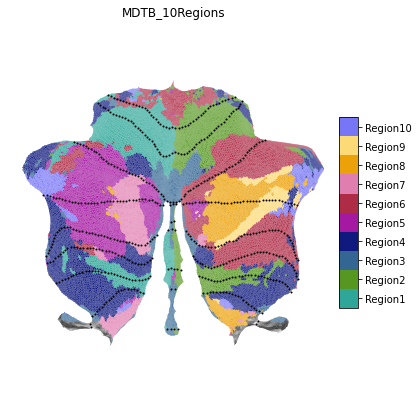

In [24]:
# plot parcellation - cerebellum
fpaths, cortex_names = nio.get_cerebellar_atlases()
@widgets.interact(parcellation=fpaths,
                 colorbar=[True, False],
                 title=[True, False])

def plot_parcellation(parcellation, colorbar, title):
    view = vis.map_atlas(parcellation, structure='cerebellum', colorbar=colorbar, title=title)

interactive(children=(Dropdown(description='parcellation', options=('/Users/maedbhking/Documents/cerebellum_co…

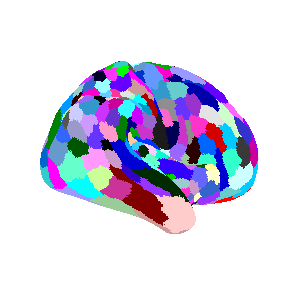

In [23]:
# plot parcellation - cortex

fpaths, cortex_names = nio.get_cortical_atlases()
@widgets.interact(parcellation=fpaths, 
                colorbar=[True, False],
                title=[False, True])

def plot_parcellation(parcellation, colorbar, title):
    view = vis.map_atlas(parcellation, structure='cortex', title=title)